In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path

import torch
import torch.utils.data
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

import pvi
from pvi.models import ClassificationBNNLocalRepam
from pvi.clients import Client
from pvi.servers import SequentialServer
from pvi.distributions import MeanFieldGaussianDistribution, MeanFieldGaussianFactor
from pvi.utils.training_utils import EarlyStopping

In [2]:
data_dir = Path("/Users/terjemildner/Desktop/data")
cache_dir = Path("/Users/terjemildner/Desktop/PVI-main/experiments/femnist")

## Define various functions for splitting data and recording performance metrics.

In [3]:
# Data splitting functions.
def homogeneous_split(data, num_clients=100, seed=42):
    # Set numpy's random seed.
    np.random.seed(seed)
    
    perm = np.random.permutation(len(data["x"]))
    client_data = []
    for i in range(num_clients):
        client_idx = perm[i::num_clients]
        print(client_idx)
        client_data.append({"x": data["x"][client_idx], "y": data["y"][client_idx]})
    
    return client_data

def heterogeneous_split(data, num_clients=100, seed=42):
    # Set numpy's random seed.
    listed = np.argsort(data["y"])

    sorted_x = data["x"][listed[::1]]
    sorted_y = data["y"][listed[::1]]
    
    l = len(data["y"])
    client_size = int(np.ceil(l/(2*num_clients)))
    
    data_parts_x = []
    data_parts_y = []
    
    for i in range(2*num_clients):
        data_parts_x.append(sorted_x[i*client_size:(i+1)*client_size]) 
        data_parts_y.append(sorted_y[i*client_size:(i+1)*client_size])
        
    rng = np.random.default_rng(seed)
    perm = rng.permutation((2*num_clients))
    
    client_data = []
    
    for i in range(num_clients):
        nums = perm[i::num_clients]
        x_data = torch.cat((data_parts_x[nums[0]], data_parts_x[nums[1]]))
        y_data = torch.cat((data_parts_y[nums[0]], data_parts_y[nums[1]]))
        client_data.append({"x": x_data, "y": y_data})
        
    return client_data

#Each shard contains only one class, classes are ordered together
def heterogeneous_split_2(data, num_clients=100):
    # Set numpy's random seed.
    listed = np.argsort(data["y"])

    sorted_x = data["x"][listed[::1]]
    sorted_y = data["y"][listed[::1]]
    
    l = len(data["y"])
    client_size = int(np.ceil(l/num_clients))
    
    client_data = []
    
    for i in range(num_clients):        
        client_data.append({"x": sorted_x[i*client_size:(i+1)*client_size], 
                            "y": sorted_y[i*client_size:(i+1)*client_size]})
    
    return client_data

#Each shard contains only one class, classes are randomly permutated
def heterogeneous_split_3(data, num_clients=100, seed=42):
    # Set numpy's random seed.
    listed = np.argsort(data["y"])

    sorted_x = data["x"][listed[::1]]
    sorted_y = data["y"][listed[::1]]
    
    l = len(data["y"])
    client_size = int(np.ceil(l/num_clients))
    
    data_parts_x = []
    data_parts_y = []
    
    for i in range(num_clients):
        data_parts_x.append(sorted_x[i*client_size:(i+1)*client_size]) 
        data_parts_y.append(sorted_y[i*client_size:(i+1)*client_size])
    
    rng = np.random.default_rng(seed)
    perm = rng.permutation(num_clients)
    
    client_data = []
    for i in range(num_clients):        
        client_idx = perm[i]
        client_data.append({"x": data_parts_x[client_idx], "y": data_parts_y[client_idx]})
    
    return client_data

# Performance metric function.
def performance_metrics(client, data, batch_size=512):
    dataset = torch.utils.data.TensorDataset(data["x"], data["y"])
    loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)
    
    device = client.config["device"]
    
    if device == "cuda":
        loader.pin_memory = True
        
    preds, mlls = [], []
    for (x_batch, y_batch) in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        pp = client.model_predict(x_batch)
        preds.append(pp.component_distribution.probs.mean(1).cpu())
        mlls.append(pp.log_prob(y_batch).cpu())
        
    mll = torch.cat(mlls).mean()
    preds = torch.cat(preds)
    acc = sum(torch.argmax(preds, dim=-1) == loader.dataset.tensors[1]) / len(
        loader.dataset.tensors[1]
    )
    
    return {"mll": mll, "acc": acc}

## Data preprocessing

In [4]:
transform_train = transforms.Compose([transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])

train_set = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform_train)
test_set = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform_test)

train_data = {
    "x": ((train_set.data - 0) / 255).reshape(-1, 28 * 28),
    "y": train_set.targets,
}

test_data = {
    "x": ((test_set.data - 0) / 255).reshape(-1, 28 * 28),
    "y": test_set.targets,
}

In [23]:
# Get client splits.
client_data = heterogeneous_split_2(train_data, 100)


## Define configuration for server and clients

In [24]:
model_config = {
    "input_dim": 784,
    "latent_dim": 200,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config = {
    "damping_factor": 1.0,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 2e-3},
    "sigma_optimiser_params": {"lr": 2e-3},
    "early_stopping": EarlyStopping(50, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 256,
    "epochs": 2500,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
}

server_config = {
    **client_config,
    #100
    "max_iterations": 10,
}

## Set up model etc.

In [25]:
device = server_config["device"]

model = ClassificationBNNLocalRepam(config=model_config)

# Initial parameters.
init_q_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model.num_parameters,)).to(device) 
    * client_config["init_var"] ** 0.5,
}

prior_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device),
    "scale": model_config["prior_var"] ** 0.5 
    * torch.ones(size=(model.num_parameters,)).to(device),
}

init_factor_nat_params = {
    "np1": torch.zeros(model.num_parameters).to(device),
    "np2": torch.zeros(model.num_parameters).to(device),
}

p = MeanFieldGaussianDistribution(
    std_params=prior_std_params, is_trainable=False
)
init_q = MeanFieldGaussianDistribution(
    std_params=init_q_std_params, is_trainable=False
)

clients = []
size_training = 0
for i in range(100):
    data_i = client_data[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params)
    clients.append(
        Client(
            data=data_i,
            model=model,
            t=t_i,
            config=client_config,
            val_data=test_data
        )
    )    
server = SequentialServer(model=model, p=p, clients=clients, config=server_config, init_q=init_q, data=train_data, val_data=test_data)

## Run PVI! Clients contain single class, clients ordered in increasing order of class label

In [26]:
i = 0
while not server.should_stop():
    server.tick()

    # Obtain performance metrics.
    metrics = server.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics["val_mll"], metrics["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics["train_mll"], metrics["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 1980.570.
Test mll: -26.272. Test acc: 0.104.
Train mll: -26.082. Train acc: 0.103.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

ValueError: Expected parameter logits (Tensor of shape (10, 256, 10)) of distribution Categorical(logits: torch.Size([10, 256, 10])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], grad_fn=<SubBackward0>)

# Heterogeneous Split, Clients contain 2 classes, ordered randomly

In [7]:
data2 = heterogeneous_split(train_data, num_clients=100, seed=42)

In [8]:
model_config = {
    "input_dim": 784,
    "latent_dim": 200,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config = {
    "damping_factor": 1.0,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 1e-3},
    "sigma_optimiser_params": {"lr": 1e-3},
    "early_stopping": EarlyStopping(25, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 512,
    "epochs": 2500,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
}

server_config = {
    **client_config,
    #100
    "max_iterations": 20,
}

In [9]:
device2 = server_config["device"]

model2 = ClassificationBNNLocalRepam(config=model_config)

# Initial parameters.
init_q_std_params = {
    "loc": torch.zeros(size=(model2.num_parameters,)).to(device2).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model2.num_parameters,)).to(device2) 
    * client_config["init_var"] ** 0.5,
}

prior_std_params = {
    "loc": torch.zeros(size=(model2.num_parameters,)).to(device2),
    "scale": model_config["prior_var"] ** 0.5 
    * torch.ones(size=(model2.num_parameters,)).to(device2),
}

init_factor_nat_params = {
    "np1": torch.zeros(model2.num_parameters).to(device2),
    "np2": torch.zeros(model2.num_parameters).to(device2),
}

p = MeanFieldGaussianDistribution(
    std_params=prior_std_params, is_trainable=False
)
init_q = MeanFieldGaussianDistribution(
    std_params=init_q_std_params, is_trainable=False
)

clients2 = []
size_training = 0
for i in range(100):
    data_i = data2[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params)
    clients2.append(
        Client(
            data=data_i,
            model=model2,
            t=t_i,
            config=client_config,
            val_data=test_data
        )
    )    
server2 = SequentialServer(model=model2, p=p, clients=clients2, config=server_config, init_q=init_q, data=train_data, val_data=test_data)

In [10]:
i = 0
while not server2.should_stop():
    server2.tick()

    # Obtain performance metrics.
    metrics2 = server2.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics2["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics2["val_mll"], metrics2["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics2["train_mll"], metrics2["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 661.731.
Test mll: -0.761. Test acc: 0.743.
Train mll: -0.742. Train acc: 0.748.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 1.
Time taken: 1414.435.
Test mll: -0.597. Test acc: 0.816.
Train mll: -0.573. Train acc: 0.820.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 2.
Time taken: 2245.432.
Test mll: -0.442. Test acc: 0.864.
Train mll: -0.426. Train acc: 0.870.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 3.
Time taken: 2758.655.
Test mll: -0.357. Test acc: 0.883.
Train mll: -0.331. Train acc: 0.889.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 4.
Time taken: 3958.299.
Test mll: -0.254. Test acc: 0.919.
Train mll: -0.234. Train acc: 0.924.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 5.
Time taken: 5805.614.
Test mll: -0.295. Test acc: 0.909.
Train mll: -0.274. Train acc: 0.915.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 6.
Time taken: 6976.369.
Test mll: -0.216. Test acc: 0.931.
Train mll: -0.196. Train acc: 0.938.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 7.
Time taken: 8704.206.
Test mll: -0.173. Test acc: 0.947.
Train mll: -0.151. Train acc: 0.955.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 8.
Time taken: 9751.286.
Test mll: -0.155. Test acc: 0.952.
Train mll: -0.129. Train acc: 0.960.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 9.
Time taken: 10942.907.
Test mll: -0.146. Test acc: 0.955.
Train mll: -0.120. Train acc: 0.963.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 10.
Time taken: 13223.161.
Test mll: -0.219. Test acc: 0.934.
Train mll: -0.210. Train acc: 0.937.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 11.
Time taken: 15434.376.
Test mll: -0.165. Test acc: 0.949.
Train mll: -0.143. Train acc: 0.958.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 12.
Time taken: 16475.241.
Test mll: -0.168. Test acc: 0.950.
Train mll: -0.142. Train acc: 0.958.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 13.
Time taken: 17277.572.
Test mll: -0.154. Test acc: 0.953.
Train mll: -0.130. Train acc: 0.961.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 14.
Time taken: 17884.980.
Test mll: -0.136. Test acc: 0.959.
Train mll: -0.111. Train acc: 0.967.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 15.
Time taken: 19660.145.
Test mll: -0.150. Test acc: 0.956.
Train mll: -0.130. Train acc: 0.962.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 16.
Time taken: 20173.673.
Test mll: -0.154. Test acc: 0.954.
Train mll: -0.128. Train acc: 0.961.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 17.
Time taken: 20958.392.
Test mll: -0.243. Test acc: 0.927.
Train mll: -0.219. Train acc: 0.935.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 18.
Time taken: 21835.913.
Test mll: -0.211. Test acc: 0.939.
Train mll: -0.184. Train acc: 0.944.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 19.
Time taken: 22651.892.
Test mll: -0.408. Test acc: 0.884.
Train mll: -0.378. Train acc: 0.890.



# Heterogeneous Split with 1 class per client, clients arranged randomly

In [19]:
data3 = heterogeneous_split_3(train_data, num_clients=100, seed=42)

In [20]:
model_config = {
    "input_dim": 784,
    "latent_dim": 200,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config = {
    "damping_factor": 1.0,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 2e-3},
    "sigma_optimiser_params": {"lr": 2e-3},
    "early_stopping": EarlyStopping(5, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 256,
    "epochs": 2500,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
}

server_config = {
    **client_config,
    #100
    "max_iterations": 10,
}

In [21]:
device3 = server_config["device"]

model3 = ClassificationBNNLocalRepam(config=model_config)

# Initial parameters.
init_q_std_params = {
    "loc": torch.zeros(size=(model3.num_parameters,)).to(device3).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model3.num_parameters,)).to(device3) 
    * client_config["init_var"] ** 0.5,
}

prior_std_params = {
    "loc": torch.zeros(size=(model3.num_parameters,)).to(device3),
    "scale": model_config["prior_var"] ** 0.5 
    * torch.ones(size=(model3.num_parameters,)).to(device3),
}

init_factor_nat_params = {
    "np1": torch.zeros(model3.num_parameters).to(device3),
    "np2": torch.zeros(model3.num_parameters).to(device3),
}

p = MeanFieldGaussianDistribution(
    std_params=prior_std_params, is_trainable=False
)
init_q = MeanFieldGaussianDistribution(
    std_params=init_q_std_params, is_trainable=False
)

clients3 = []
size_training = 0
for i in range(100):
    data_i = data3[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params)
    clients3.append(
        Client(
            data=data_i,
            model=model3,
            t=t_i,
            config=client_config,
            val_data=test_data
        )
    )    
server3 = SequentialServer(model=model3, p=p, clients=clients3, config=server_config, init_q=init_q, data=train_data, val_data=test_data)

In [22]:
i = 0
while not server3.should_stop():
    server3.tick()

    # Obtain performance metrics.
    metrics3 = server3.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics3["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics3["val_mll"], metrics3["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics3["train_mll"], metrics3["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 659.824.
Test mll: -2.360. Test acc: 0.104.
Train mll: -2.361. Train acc: 0.107.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 1.
Time taken: 771.994.
Test mll: -2.375. Test acc: 0.128.
Train mll: -2.375. Train acc: 0.128.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 2.
Time taken: 860.195.
Test mll: -2.265. Test acc: 0.171.
Train mll: -2.271. Train acc: 0.172.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 3.
Time taken: 938.229.
Test mll: -2.004. Test acc: 0.231.
Train mll: -2.013. Train acc: 0.230.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 4.
Time taken: 1003.032.
Test mll: -1.950. Test acc: 0.238.
Train mll: -1.958. Train acc: 0.244.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 5.
Time taken: 1063.577.
Test mll: -1.893. Test acc: 0.260.
Train mll: -1.901. Train acc: 0.262.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 6.
Time taken: 1132.081.
Test mll: -1.815. Test acc: 0.290.
Train mll: -1.820. Train acc: 0.297.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 7.
Time taken: 1201.147.
Test mll: -1.758. Test acc: 0.321.
Train mll: -1.762. Train acc: 0.329.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 8.
Time taken: 1314.246.
Test mll: -1.703. Test acc: 0.356.
Train mll: -1.697. Train acc: 0.353.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 9.
Time taken: 1425.792.
Test mll: -1.655. Test acc: 0.375.
Train mll: -1.642. Train acc: 0.376.



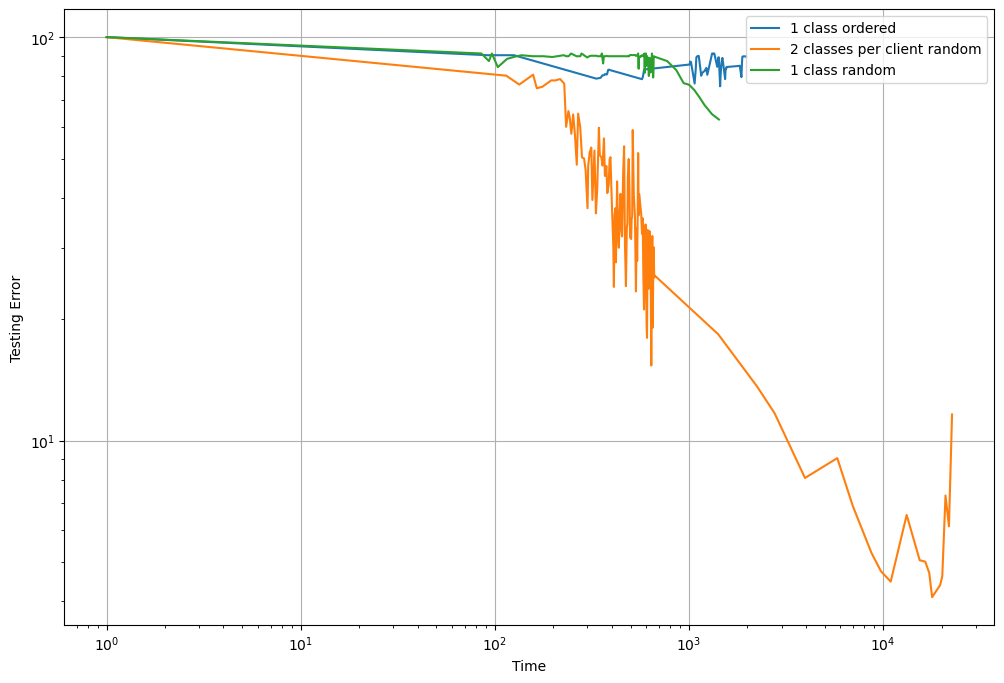

In [44]:
train_acc = []
val_acc = []
times = []
train_acc.append(100.0)
val_acc.append(100.0)
times.append(1.0)
for metrics in server.log["performance_metrics"]:
    train_acc.append(100-metrics["train_acc"]*100)
    val_acc.append(100-metrics["val_acc"]*100)
    times.append(metrics["time"])
    
train_acc2 = []
val_acc2 = []
times2 = []
train_acc2.append(100.0)
val_acc2.append(100.0)
times2.append(1.0)
for metrics in server2.log["performance_metrics"]:
    train_acc2.append(100-metrics["train_acc"]*100)
    val_acc2.append(100-metrics["val_acc"]*100)
    times2.append(metrics["time"])
    
train_acc3 = []
val_acc3 = []
times3 = []
train_acc3.append(100.0)
val_acc3.append(100.0)
times3.append(1.0)
for metrics in server3.log["performance_metrics"]:
    train_acc3.append(100-metrics["train_acc"]*100)
    val_acc3.append(100-metrics["val_acc"]*100)
    times3.append(metrics["time"])
    
plt.figure(figsize=(12,8))
plt.xscale("log")
plt.yscale("log")
plt.plot(times, val_acc, label="1 class ordered")
plt.plot(times2, val_acc2, label="2 classes per client random")
plt.plot(times3, val_acc3, label="1 class random")
plt.grid(visible=True)
plt.xlabel("Time")
plt.ylabel("Testing Error")
plt.legend(loc="upper right")
plt.savefig("Heterogeneous PVI on MNIST.png")
plt.show()